In [1]:
# Imports
import cv2
import os
import numpy as np
import pandas as pd
import shutil
import kagglehub
import keras

import tensorflow as tf
from keras.applications import ResNet50V2, MobileNetV2
from keras import layers, models
from keras.optimizers import Adam
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization
from keras.src.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt

## Handtracking and Image modification
from cvzone.HandTrackingModule import HandDetector
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops

/home/lizardman/Coding/Projet_Machine_Learning_Air_Drawing/venv312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-07 16:27:21.706662: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 16:27:21.712833: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 16:27:21.767133: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 16:27:21.819968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register

# Projet - Air Drawing
---
EXPLICATION DE LA PROBLEMATIQUE

## Datsets
---

### Autre Dataset
Explication de pourquoi est ce qu'on ne la pas pris car moins bien etc
Solution : EMNIST

### EMNIST
Le jeu de données EMNIST (Extended MNIST) est un ensemble de caractères manuscrits dérivé de la base de données NIST Special Database 19. Il a été converti au format d’image 28x28 pixels, avec une structure de données qui correspond directement à celle du jeu de données MNIST. EMNIST étend MNIST en incluant non seulement des chiffres, mais aussi des lettres majuscules et minuscules manuscrites, offrant ainsi un ensemble plus riche pour les tâches de reconnaissance de caractères.

In [2]:
# Télécharger dans le dossier par défaut non modifiable (cache de kagglehub)
dataset_path = kagglehub.dataset_download("crawford/emnist")

# Dossier cible
custom_path = "./Datasets/emnist_datasets"
os.makedirs(custom_path, exist_ok=True)

# Parcourir tout ce qu’il y a dans dataset_path
for item in os.listdir(dataset_path):
    src = os.path.join(dataset_path, item)
    dst = os.path.join(custom_path, item)
    shutil.move(src, dst)

### EMNIST (By_Class)
L'ensemble complet de la base de données EMNIST est disponible dans le sous-ensembles ByClass.
Le jeu ByClass contient 62 classes distinctes : les 10 chiffres (0–9), les 26 lettres majuscules (A–Z) et les 26 lettres minuscules (a–z).
La répartition est déséquilibrée : certaines classes ont beaucoup plus d’exemples que d’autres.
La fréquence des lettres reflète à peu près leur fréquence d'usage dans la langue anglaise.

__Taille des ensembles :__
- Entraînement : 697 932 images
- Test : 116 323 images
- Total : 814 255 images

__Classes :__
- ByClass : 62 classes (déséquilibrées)


In [3]:
# Recupération des train_data de EMNITST
#train_data = pd.read_csv('./Datasets/emnist_datasets/emnist-byclass-train.csv', header=None, nrows=300000).to_numpy()
train_data = pd.read_csv('./Datasets/emnist_datasets/emnist-byclass-train.csv', header=None, nrows=50000).to_numpy()
# Dataset Comprends 697 932 entrées, par raison de performances nous avons limités la charge à 300K.
print(train_data.shape)

(50000, 785)


In [4]:
# Recupération des test_data de EMNITST
#test_data = pd.read_csv('./Datasets/emnist_datasets/emnist-byclass-test.csv', header=None).to_numpy()
test_data = pd.read_csv('./Datasets/emnist_datasets/emnist-byclass-test.csv', header=None, nrows=30000).to_numpy()
print(test_data.shape)

(30000, 785)


Les test_data permet au modèle de voir s'il se généralise bien et qu'il ne fait pas du sur-apprentissage (évaluation époque par époque).
Pratique pour stopper ou débugger l'entrainement du modèle.

W


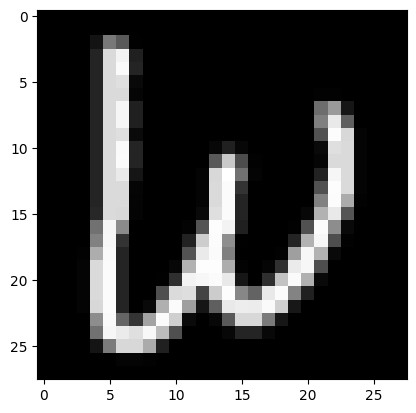

In [5]:
# Recupération des label_mapping de EMNITST
label_mapping = np.genfromtxt('./Datasets/emnist_datasets/emnist-byclass-mapping.txt', delimiter=' ')

label_trans = {}
for label in label_mapping:
    label_trans[label[0]] = chr(int(label[1]))

# Exemple d'une donnée EMNIST
img_nb = 150
print(label_trans[train_data[img_nb,0]])
plt.imshow(train_data[img_nb,1:].reshape(28,28).T, cmap='gray')
plt.show()

In [6]:
# Préparation des données :

# 1) Séparation des labels "y" et les données de l'image "x"
# Entrainement
train_x = train_data[:,1:]
train_y = train_data[:,0]
# Test
test_x = test_data[:,1:]
test_y = test_data[:,0]

# 2) Normalisation (valeur des "x" entre 0 et 1) -> Plus facile pour l'entrainement
train_x = train_x / 255.0
test_x = test_x / 255.0

# 3) Reshape (Keras attend un format [batch_size, hauteur, largeur, canaux])
train_count = train_x.shape[0]
train_x = train_x.reshape(train_count, 28, 28, 1)

test_count = test_x.shape[0]
test_x = test_x.reshape(test_count, 28, 28, 1)

# 4) Transformation des labels (Chiffre en vecteur binaire)
num_classes = 63 # (62 catégorie allant de 1 à 62 donc liste de longueur 63)

train_y = keras.utils.to_categorical(train_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

Nos données provenant du dataset EMNIST(By_Class) sont maintanant pretes à etre utiliser dans nos différents modèle.

### EMNIST (Letters)
Le jeu de données EMNIST Letters fusionne un ensemble équilibré de lettres majuscules et minuscules en une seule tâche de classification à 26 classes (une par lettre de l’alphabet).

- Entraînement : 88 800 images
- Test : 14 800 images
- Total : 103 600 images
- Nombre de classes : 26 (répartition équilibrée)


## Entrainement de lettres
---

### Option A (CNN Maison)

#### CCN Maison 1

##### Modèle

In [ ]:
# Définition du premier modèle
model_cnn1 = Sequential()

# Creating conv layer 1
model_cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=[28, 28, 1]))
model_cnn1.add(LeakyReLU(alpha=0.1))
model_cnn1.add(MaxPooling2D((2, 2), padding='same'))
model_cnn1.add(Dropout(0.25))

# Creating conv layer 2
model_cnn1.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model_cnn1.add(LeakyReLU(alpha=0.1))
model_cnn1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_cnn1.add(Dropout(0.25))

# Adding the dense final part
model_cnn1.add(Flatten())
model_cnn1.add(Dense(1024, activation='linear'))
model_cnn1.add(LeakyReLU(alpha=0.1))
model_cnn1.add(Dropout(0.25))
model_cnn1.add(Dense(num_classes, activation='softmax'))

model_cnn1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn1.summary()

In [ ]:
# Apprentissage du modèle
model_cnn1_history = model_cnn1.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10)

##### Tableau d'apprentissage

In [ ]:
# Valeurs importantes lors de l'apprentissage du modèle
model_train_acc_cnn1 = model_cnn1_history.history['accuracy']
model_valid_acc_cnn1 = model_cnn1_history.history['val_accuracy']
model_train_loss_cnn1 = model_cnn1_history.history['loss']
model_valid_loss_cnn1 = model_cnn1_history.history['val_loss']

# Graphiques de l'apprentissage
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

# Accuracy graph
ax0.plot(model_train_acc_cnn1, label="Train Acc.")
ax0.plot(model_valid_acc_cnn1, label="Valid. Acc.")

ax0.set_xlabel('Epoch')
ax0.set_ylabel('Accuracy(%)')
ax0.legend(loc='lower right', fancybox=True, shadow=True, ncol=4)
ax0.grid()

# Loss graph
ax1.plot(model_train_loss_cnn1, label="Train Loss")
ax1.plot(model_valid_loss_cnn1, label="Valid. Loss")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', fancybox=True, shadow=True, ncol=4)
ax1.grid()

#### CCN Maison 2

##### Modèle

In [ ]:
# Définition du deuxième modèle
model_cnn2 = Sequential()

# Convolution 1
model_cnn2.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
model_cnn2.add(BatchNormalization())
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.2))

# Convolution 2
model_cnn2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.3))

# Convolution 3
model_cnn2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.4))

# Dense layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(256))
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(Dropout(0.5))

model_cnn2.add(Dense(num_classes, activation='softmax'))

# Compilation
model_cnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé
model_cnn2.summary()

In [ ]:
# Apprentissage du modèle
model_cnn2_history = model_cnn2.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10)

##### Tableau d'apprentissage

In [ ]:
# Valeurs importantes lors de l'apprentissage du modèle
model_train_acc_cnn2 = model_cnn2_history.history['accuracy']
model_valid_acc_cnn2 = model_cnn2_history.history['val_accuracy']
model_train_loss_cnn2 = model_cnn2_history.history['loss']
model_valid_loss_cnn2 = model_cnn2_history.history['val_loss']

# Graphiques de l'apprentissage
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

# Accuracy graph
ax0.plot(model_train_acc_cnn2, label="Train Acc.")
ax0.plot(model_valid_acc_cnn2, label="Valid. Acc.")

ax0.set_xlabel('Epoch')
ax0.set_ylabel('Accuracy(%)')
ax0.legend(loc='lower right', fancybox=True, shadow=True, ncol=4)
ax0.grid()

# Loss graph
ax1.plot(model_train_loss_cnn2, label="Train Loss")
ax1.plot(model_valid_loss_cnn2, label="Valid. Loss")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', fancybox=True, shadow=True, ncol=4)
ax1.grid()

### Option B (Transfert Learning)

#### Transfer Learning 1 (MobileNetV2)

##### Modèle Feature Extraction

In [7]:
# Fonction de preprocessing standard (inchangée)
def preprocess(x, y):
    x = tf.image.grayscale_to_rgb(x)  # Convert grayscale to RGB (28x28x1 -> 28x28x3)
    x = tf.image.resize(x, (160, 160))  # Resize to 160x160 for faster training
    x = tf.cast(x, tf.float32) / 255.0  # Normalize to [0, 1]
    return x, y

# Data Augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Flip horizontal et vertical
    layers.RandomRotation(0.2),  # Rotation aléatoire jusqu'à 20%
    layers.RandomZoom(0.2),  # Zoom aléatoire jusqu'à 20%
], name="data_augmentation")

# Préparation du jeu d'entraînement avec augmentation
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Préparation du jeu de test → PAS d'augmentation
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2 pre-trained on ImageNet, excluding the top (classification) layers
base_model_tle_tf = MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3))

# Freeze the base model to perform feature extraction
base_model_tle_tf.trainable = False

# Build the model with a custom classifier on top of MobileNetV2
model_tle_tf = models.Sequential([
    base_model_tle_tf,  # MobileNetV2 as feature extractor
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce the feature map size
    layers.Dense(128, activation='relu'),  # Dense layer for classification
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(63, activation='softmax')  # Output layer with 63 classes (EMNIST Letters)
])

# Compile the model with a smaller learning rate for stability
model_tle_tf.compile(optimizer=Adam(learning_rate=0.0005),
                     loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
                     metrics=['accuracy'])

print("Model compiled...")

# Early stopping to prevent overfitting and save time if the model stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Model summary
model_tle_tf.summary()

2025-06-07 16:27:50.640947: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model compiled...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 63)             │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,079 (9.27 MB)

 Trainable params: 172,095 (672.25 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
print("Training...")
# Train the model using feature extraction (base model frozen)
history = model_tle_tf.fit(train_ds, validation_data=test_ds, epochs=4, callbacks=[early_stopping], verbose=1)
print("Training finish")

Training...
Epoch 1/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 473s 301ms/step - accuracy: 0.0458 - loss: 3.8607 - val_accuracy: 0.0682 - val_loss: 3.7261
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 476s 304ms/step - accuracy: 0.0508 - loss: 3.7388 - val_accuracy: 0.0579 - val_loss: 3.6840
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 489s 313ms/step - accuracy: 0.0503 - loss: 3.7316 - val_accuracy: 0.0579 - val_loss: 3.6787
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 459s 293ms/step - accuracy: 0.0514 - loss: 3.7258 - val_accuracy: 0.0579 - val_loss: 3.6808
Training finish


##### Tableau d'apprentissage (Feature Extraction)

##### Modèle Fine-tuning

In [8]:
base_model_tle_tf.trainable = True

# Definie la partie a dégeler
fine_tune_at = len(base_model_tle_tf.layers) - 15

# Re-compile avec learning rate plus faible
model_tle_tf.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_tle_tf.summary()

history_fine_tuning = model_tle_tf.fit(train_ds, validation_data=test_ds, epochs=1, callbacks=[early_stopping], verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 63)             │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,079 (9.27 MB)

 Trainable params: 2,395,967 (9.14 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1631s 1s/step - accuracy: 0.0757 - loss: 4.0729 - val_accuracy: 0.0541 - val_loss: 3.9930
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1607s 1s/step - accuracy: 0.2985 - loss: 2.9165 - val_accuracy: 0.0480 - val_loss: 4.0876
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1605s 1s/step - accuracy: 0.4152 - loss: 2.3924 - val_accuracy: 0.1334 - val_loss: 3.6801
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1602s 1s/step - accuracy: 0.4902 - loss: 2.0622 - val_accuracy: 0.5994 - val_loss: 1.5492


Modification du fine tuning :

1. Nous dégelons tous les layers apres le 100, les premiers layers ont généralement une vision génériques (bord, textures, etc)
et donc n'ont pas besoin d'être modifier pour améliorer les prédictions. Ce qui est l'inverses des derniers layers
qui sont ceux qui doivent être les plus adaptés pour notre dataset
2. Learning rate est aussi plus faible pour éviter de détruire les poids pré-entrainer
mais simplement les affiners
3. Nombre d'époch faibles pour éviter l'overfiting

##### Tableau d'apprentissage (Fine-tuning)

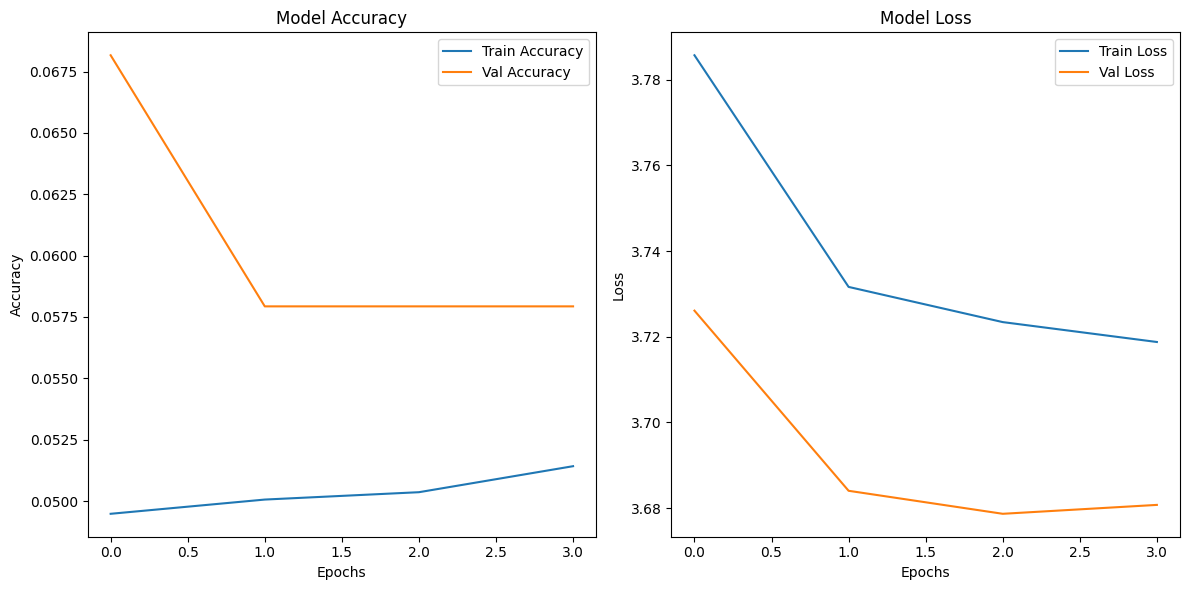

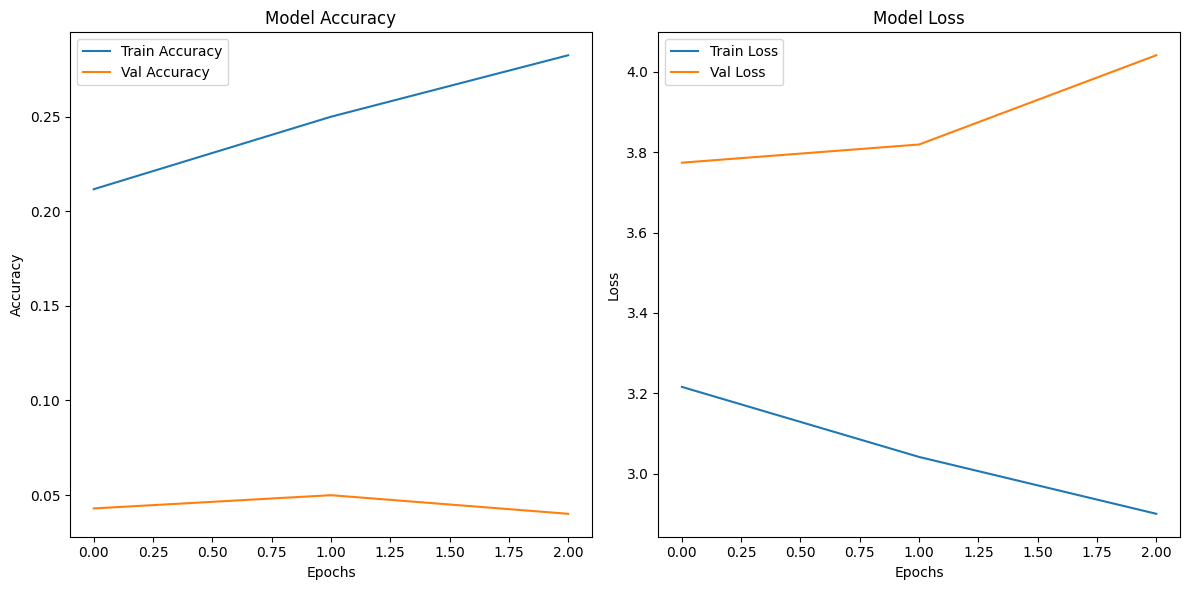

In [28]:
# Visualize the training history (accuracy and loss)
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the results after feature extraction
plot_training_history(history)

# If fine-tuning was performed, visualize it as well
plot_training_history(history_fine_tuning)


#### Transfer Learning 2 (ResNet50V2)

##### Modèle Feature Extraction

In [ ]:
# Load EMNIST Letters dataset
def load_emnist_letters(root="./data", train=True):
    return torchvision.datasets.EMNIST(
        root=root,
        split="letters",
        train=train,
        download=False,
        transform=torchvision.transforms.ToTensor()
    )

In [ ]:
# Convert EMNIST to numpy arrays
def emnist_to_numpy(dataset, max_samples=None):
    images = []
    labels = []
    for i, (img, label) in enumerate(dataset):
        if max_samples and i >= max_samples:
            break
        img_np = img.numpy().squeeze()
        images.append(img_np)
        labels.append(label - 1)  # EMNIST Letters labels start at 1
    return np.array(images), np.array(labels)

In [ ]:
# Build the transfer learning model
def build_transfer_model():
    base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model for feature extraction

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
def build_transfer_model():
    base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(26, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Batch the data
def create_emnist_tf_dataset(images, labels, batch_size=32, shuffle=True):
    def preprocess(x, y):
        x = tf.stack([x, x, x], axis=-1)
        x = tf.image.resize(x, [224, 224])
        return x, y
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
train_dataset = load_emnist_letters(train=True)
test_dataset = load_emnist_letters(train=False)
train_images, train_labels = emnist_to_numpy(train_dataset, max_samples=10000)
test_images, test_labels = emnist_to_numpy(test_dataset, max_samples=2000)
train_ds = create_emnist_tf_dataset(train_images, train_labels)
test_ds = create_emnist_tf_dataset(test_images, test_labels, shuffle=False)

# Train the model
model_CNN1 = build_transfer_model()
history = model_CNN1.fit(train_ds, validation_data=test_ds, epochs=5)

##### Tableau d'apprentissage (Feature Extraction)

In [ ]:
# 1. Unfreeze top layers of the base model
base_tle_tf_model = model_CNN1.layers[0]  # Access MobileNetV2 inside the Sequential
base_tle_tf_model.trainable = True

# 2. Freeze most layers, keep top N trainable
for layer in base_tle_tf_model.layers[:-30]:
    layer.trainable = False

# 3. Recompile with a very low learning rate
from keras.optimizers import Adam
model_CNN1.compile(optimizer=Adam(learning_rate=1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 4. Continue training
fine_tune_epochs = 3
model_CNN1.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)

In [ ]:
# 0. Unfreeze top layers of the base model
base_tle_tf_model = model_CNN1.layers[-1]  # Access MobileNetV2 inside the Sequential
base_tle_tf_model.trainable = True

# 1. Freeze most layers, keep top N trainable
for layer in base_tle_tf_model.layers[:-31]:
    layer.trainable = False

# 2. Recompile with a very low learning rate
from keras.optimizers import Adam
model_CNN1.compile(optimizer=Adam(learning_rate=0e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 3. Continue training
fine_tune_epochs = 2
model_CNN1.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)

##### Modèle Fine-tuning

In [ ]:
# 1. Unfreeze top layers of the base model
base_tle_tf_model = model_CNN1.layers[0]  # Access MobileNetV2 inside the Sequential
base_tle_tf_model.trainable = True

# 2. Freeze most layers, keep top N trainable
for layer in base_tle_tf_model.layers[:-30]:
    layer.trainable = False

# 3. Recompile with a very low learning rate
from keras.optimizers import Adam
model_CNN1.compile(optimizer=Adam(learning_rate=1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 4. Continue training
fine_tune_epochs = 3
model_CNN1.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)

##### Tableau d'apprentissage (Fine-tuning)

In [ ]:
# TO DO

## Évaluation Comparative et Analyse Critique
---
Explication et résumer des résultat avec les tableaux etc
Meilleur modele dans quel cas et pourquoi (temps, MSE, accuracy, etc)

## Application réel du projet
---

### Vidéo


In [ ]:
# === Fonctions utilitaires ===
def vider_dossier(dossier):
    if os.path.exists(dossier):
        for f in os.listdir(dossier):
            chemin = os.path.join(dossier, f)
            if os.path.isfile(chemin):
                os.remove(chemin)
    else:
        os.makedirs(dossier)

# === 0. Définition des chemins ===
BASE_DIR = os.path.dirname(os.path.abspath(__file__))

print(BASE_DIR)
video_path = os.path.join(BASE_DIR, 'Result/videos/Lettres/I.mp4')
extracted_dir = os.path.join(BASE_DIR, 'images_extraites')
finger_dir = os.path.join(BASE_DIR, 'finger_find')
frame_interval = 2

# === 1. Nettoyage des dossiers ===
vider_dossier(extracted_dir)
vider_dossier(finger_dir)

# === 2. Extraction des frames ===
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Erreur : impossible d'ouvrir la vidéo '{video_path}'")
    exit()

fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Vidéo chargée : {total_frames} frames à {fps:.2f} fps")

frame_count = 0
saved_count = 0

while True:
    success, frame = cap.read()
    if not success:
        break

    if frame_count % frame_interval == 0:
        filename = os.path.join(extracted_dir, f"frame_{saved_count:04d}.jpg")
        cv2.imwrite(filename, frame)
        saved_count += 1

    frame_count += 1

cap.release()
print(f"{saved_count} images extraites dans le dossier '{extracted_dir}'")

# === 3. Détection du bout de l'index ===
trace_points = []
img_shape = None
detector = HandDetector(staticMode=True, maxHands=1, detectionCon=0.7)

#for filename in os.listdir(extracted_dir):
for filename in sorted(os.listdir(extracted_dir)):
    if not filename.endswith(('.jpg', '.png')):
        continue

    image_path = os.path.join(extracted_dir, filename)
    image = cv2.imread(image_path)
    hands, img = detector.findHands(image)

    if hands:
        hand = hands[0]
        lm_list = hand['lmList']
        if len(lm_list) >= 9:
            x, y = lm_list[8][0], lm_list[8][1]
            trace_points.append((x, y))

    #cv2.imwrite(os.path.join(finger_dir, filename), img)

# === 4. Génération de l'image composite ===
#sample_img = cv2.imread(os.path.join(finger_dir, os.listdir(finger_dir)[0]))
if img_shape is None:
    img_shape = image.shape

height, width, _ = img_shape
result = np.zeros((height, width, 3), dtype=np.uint8)

for i in range(1, len(trace_points)):
    cv2.line(result, trace_points[i - 1], trace_points[i], (0, 0, 255), thickness=6)

# === 5. Rotation de 90° vers la droite ===
rotated = cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)

# === 6. Effet miroir (symétrie horizontale) ===
mirrored = cv2.flip(rotated, 1)

# === 7. Sauvegarde de l'image finale ===
cv2.imwrite("../image_resultat.png", mirrored)
print("Image finale enregistrée sous 'image_resultat.png' (rotation + effet miroir)")


### Traitements d'image

In [ ]:
def save_step_logs(image, name, output_dir="debug_steps"):
    os.makedirs(output_dir, exist_ok=True)
    if image is None or image.size == 0:
        print(f"[WARNING] Cannot save '{name}': image is empty.")
        return
    cv2.imwrite(os.path.join(output_dir, f"{name}.png"), image)

# Step 1: Extract red from image
def extract_red_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    return cv2.bitwise_or(mask1, mask2)

# Step 2: Basic cleaning (open/close)
def clean_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Step 3: Keep relevant parts
def filter_components(mask, min_area=50):
    labeled = label(mask)
    cleaned = np.zeros_like(mask)
    for region in regionprops(labeled):
        if region.area >= min_area:
            for y, x in region.coords:
                cleaned[y, x] = 255
    return cleaned

# Step 4: Skeletonize
def get_skeleton(mask):
    return (skeletonize(mask > 0) * 255).astype(np.uint8)

# Step 5 : Bold the ligne
def thicken_mask(mask, size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
    return cv2.dilate(mask, kernel, iterations=1)

# Step 6: Resize and center
def center_and_resize(mask, output_size=28, margin=2):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.ones((output_size, output_size), dtype=np.uint8) * 255
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    cropped = mask[y:y+h, x:x+w]
    resized = cv2.resize(cropped, (output_size - 2 * margin, output_size - 2 * margin))
    canvas = np.ones((output_size, output_size), dtype=np.uint8) * 255
    cx = (output_size - resized.shape[1]) // 2
    cy = (output_size - resized.shape[0]) // 2
    canvas[cy:cy + resized.shape[0], cx:cx + resized.shape[1]] = 255 - resized

    return canvas

# Main function
def process_image(path, output_dir="debug_steps"):
    img = cv2.imread(path)
    save_step_logs(img, "00_original", output_dir)

    mask = extract_red_mask(img)
    save_step_logs(mask, "01_red_mask", output_dir)

    cleaned = clean_mask(mask)
    save_step_logs(cleaned, "02_cleaned", output_dir)

    filtered = filter_components(cleaned)
    save_step_logs(filtered, "03_filtered", output_dir)

    skeleton = get_skeleton(filtered)
    save_step_logs(skeleton, "04_skeleton", output_dir)

    thickened = thicken_mask(skeleton, size=50)
    save_step_logs(thickened, "05_thickened", output_dir)

    final = center_and_resize(thickened)
    save_step_logs(final, "06_final", output_dir)

    print("[INFO] Simplified processing complete.")
    cv2.imwrite(os.path.join("../Resultats/Conversion", "result.png"), final)

    return final

# Run on your image
process_image("../image_resultat.png")

### Application du Meilleur Modèle entrainé sur l'image


In [ ]:
# TO DO

## Conclusions et Décisions
---
TO DO